# Visualization of Utah COVID-19 Cases for 2020

Inspriation for these visualizations came from [Matt Harrison's](https://www.linkedin.com/in/panela/) daily COVID-19 plots that he began publishing on LinkedIn during the spring of 2020.

In [1]:
%matplotlib inline

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

Let me see all columns

In [3]:
pd.options.display.max_columns = 999

This is required to eliminate a pandas deprecation warning related to implicit datetime conversions.

In [4]:
pd.plotting.register_matplotlib_converters()

Raw data location on Github

In [5]:
url = ('https://github.com/COVID19Tracking/covid-tracking-data/'
       'raw/master/data/states_daily_4pm_et.csv')

In [6]:
df = pd.read_csv(url, parse_dates=['date', 'dateChecked'])

In [7]:
df[df['state'] == 'UT'].head()

,date,state,positive,negative,pending,hospitalizedCurrently,hospitalizedCumulative,inIcuCurrently,inIcuCumulative,onVentilatorCurrently,onVentilatorCumulative,recovered,dataQualityGrade,lastUpdateEt,hash,dateChecked,death,hospitalized,total,totalTestResults,posNeg,fips,deathIncrease,hospitalizedIncrease,negativeIncrease,positiveIncrease,totalTestResultsIncrease
48,2020-05-12,UT,6432.0,147053.0,NaN,166.0,535.0,NaN,178.0,NaN,80.0,3267.0,B,5/12/2020 15:00,529a080f15d8f439a8f5d45ba54214b08fd1cdbc,2020-05-12 20:00:00+00:00,73.0,535.0,153485,153485,153485,49,5.0,18.0,2830.0,70.0,2900.0
104,2020-05-11,UT,6362.0,144223.0,NaN,160.0,517.0,NaN,169.0,NaN,76.0,3181.0,B,5/11/2020 15:00,fd0ee60a58a8dba6346a766037e5c849819ee5c8,2020-05-11 20:00:00+00:00,68.0,517.0,150585,150585,150585,49,1.0,5.0,3964.0,111.0,4075.0
160,2020-05-10,UT,6251.0,140259.0,NaN,144.0,512.0,NaN,168.0,NaN,76.0,3033.0,B,5/10/2020 10:31,95436551c2b902b219be9d3207ee419385b7bac2,2020-05-10 20:00:00+00:00,67.0,512.0,146510,146510,146510,49,1.0,14.0,3068.0,148.0,3216.0
216,2020-05-09,UT,6103.0,137191.0,NaN,172.0,498.0,NaN,166.0,NaN,75.0,2901.0,B,5/9/2020 10:32,3c83518dba343f7639c59cd83af6d40488fbd5df,2020-05-09 20:00:00+00:00,66.0,498.0,143294,143294,143294,49,5.0,10.0,4422.0,184.0,4606.0
272,2020-05-08,UT,5919.0,132769.0,NaN,216.0,488.0,NaN,162.0,NaN,73.0,2769.0,B,5/8/2020 15:00,c4ea753cfa02e60f4960bb3f95b6219c42ce5fd2,2020-05-08 20:00:00+00:00,61.0,488.0,138688,138688,138688,49,0.0,12.0,3950.0,195.0,4145.0


In [8]:
days = mdates.DayLocator()
months = mdates.MonthLocator()
formatter = mdates.ConciseDateFormatter(days)

In [9]:
sns.set(context='talk', palette='deep', color_codes=True, style='darkgrid')

## Matt Harrison's Original Plot

With some added `seaborn` styling....

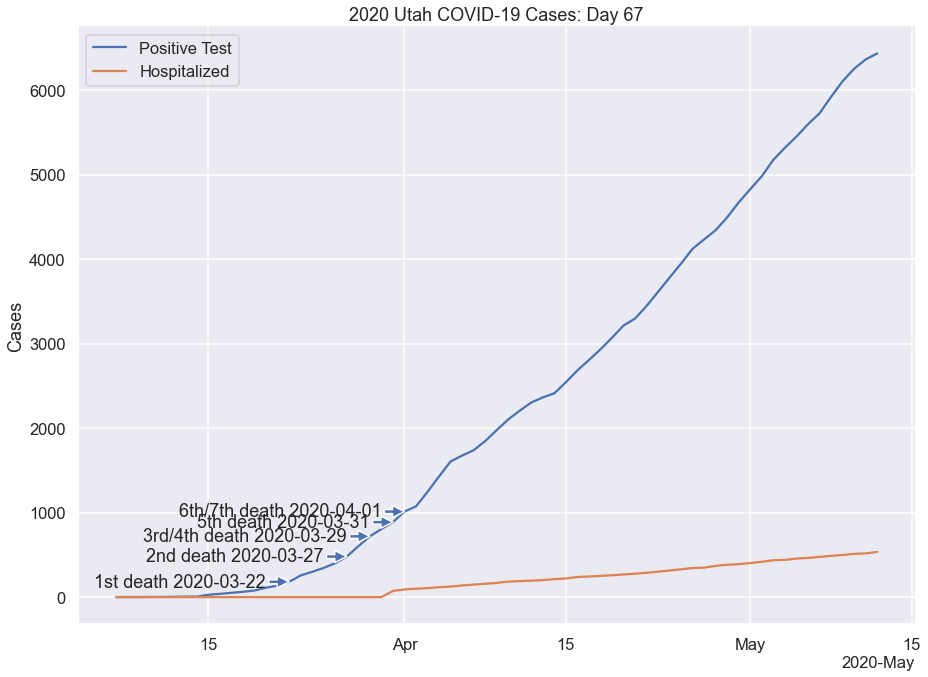

In [10]:
with sns.plotting_context('talk'):
    data = (df
            [df.state == 'UT']
            .set_index('date')
            [['positive', 'hospitalized', 'death']]
            .fillna(0)
           )
    fig, ax = plt.subplots(figsize=(15, 11))
    ax.plot(data.positive, label='Positive Test')
    ax.plot(data.hospitalized, label='Hospitalized')
    ax.set_ylabel('Cases')
    ax.set_title(f'2020 Utah COVID-19 Cases: Day {data.shape[0]}')

#     ax.xaxis.set_major_locator(days)
    ax.xaxis.set_major_formatter(formatter)
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=0)
    
    deaths = [
        ('1st', pd.Timestamp('2020-03-22')),
        ('2nd', pd.Timestamp('2020-03-27')),
        ('3rd/4th', pd.Timestamp('2020-03-29')),
        ('5th', pd.Timestamp('2020-03-31')),
        ('6th/7th', pd.Timestamp('2020-04-01'))
    ]
    
    for num, date in deaths:
        val = data.loc[date, 'positive']
        ax.annotate(f'{num} death {date.strftime("%Y-%m-%d")}',
                    xy=(date, val),
                    xytext=(date - pd.DateOffset(days=2), val),
                    arrowprops={},
                    horizontalalignment='right',
                    verticalalignment='center'
                   )
    sns.despine()
    ax.legend(loc='upper left')

## Break Out Subplots

How does it look if we break everything out into subplots instead?

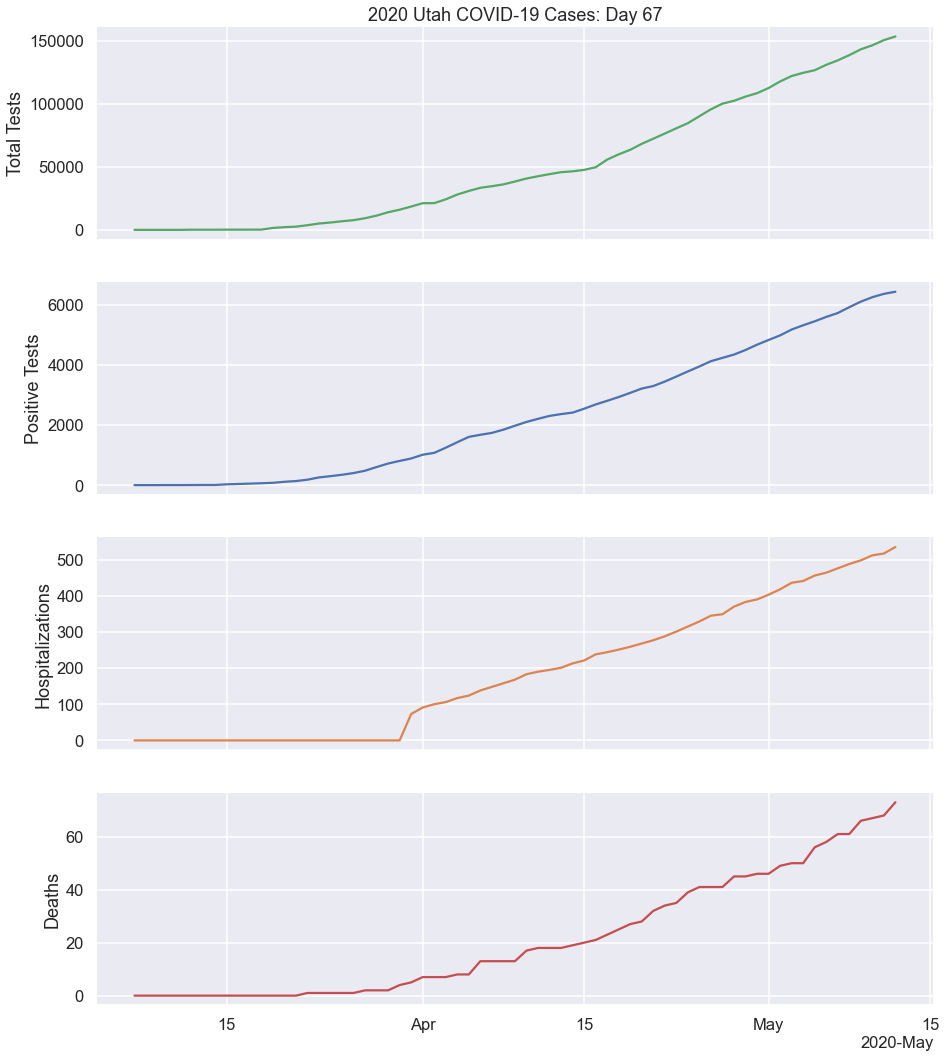

In [11]:
with sns.plotting_context('talk'):
    data = (df
            [df.state == 'UT']
            .set_index('date')
            [['positive', 'hospitalized', 'death', 'totalTestResults']]
            .fillna(0)
           )
    fig, ax = plt.subplots(4, 1, figsize=(15, 18), sharex=True)
 
    ax[0].plot(data.totalTestResults, color='C2', label='Total Tests')
    ax[0].set_ylabel('Total Tests')
    ax[0].set_title(f'2020 Utah COVID-19 Cases: Day {data.shape[0]}')
    
    ax[1].plot(data.positive, color='C0', label='Positive Test')
    ax[1].set_ylabel('Positive Tests')
    
    ax[2].plot(data.hospitalized, color='C1', label='Hospitalized')
    ax[2].set_ylabel('Hospitalizations')
    
    ax[3].plot(data.death, color='C3', label='Deaths')
    ax[3].set_ylabel('Deaths')

#     ax[0].xaxis.set_major_locator(days)
    ax[0].xaxis.set_major_formatter(formatter)
    plt.setp(ax[0].xaxis.get_majorticklabels(), rotation=0)
    
    sns.despine()

## Multiple Y-Axes on Single Plot

The subplots indicate similar curve shapes. Let's express them on a common plot with multiple y axes. Additionally, let's ignore the missing hospitalization data rather than fill it with zeros.

Inspiration for the multiple axes technique comes from the [Multiple Yaxis Wtih Spines](https://matplotlib.org/3.1.1/gallery/ticks_and_spines/multiple_yaxis_with_spines.html) example on the matplotlib site.

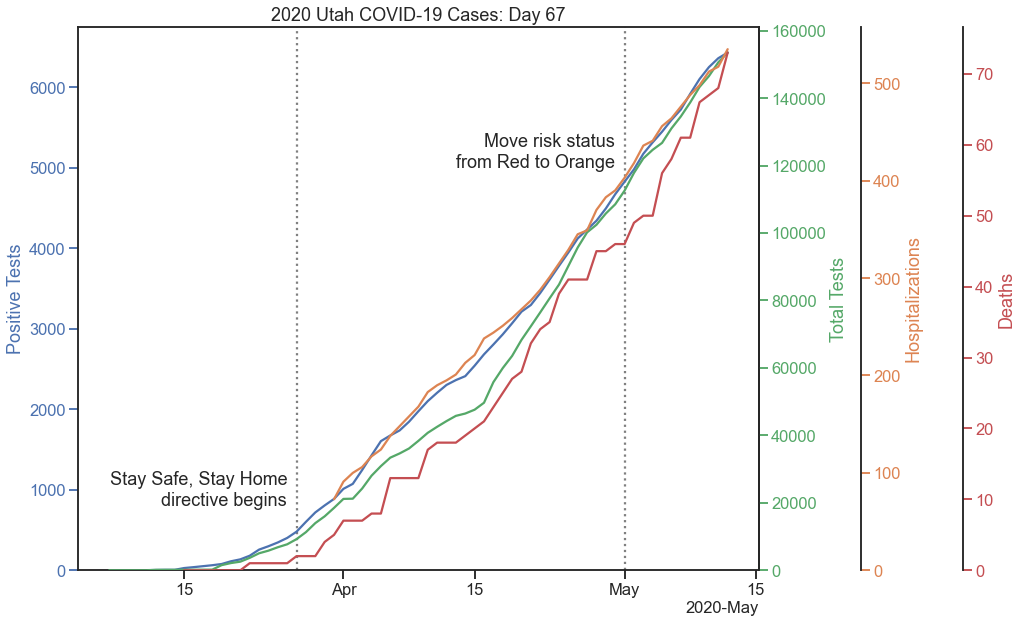

In [12]:
def make_patch_spines_invisible(ax):
    ax.set_frame_on(True)
    ax.patch.set_visible(False)
    for sp in ax.spines.values():
        sp.set_visible(False)

with sns.axes_style('ticks'):
    data = (df
            [df.state == 'UT']
            .set_index('date')
            [['positive', 'hospitalized', 'death', 'totalTestResults']]
#             .fillna(0)
           )
    fig, ax_0 = plt.subplots(1, 1, figsize=(18, 10), sharex=True)
    fig.subplots_adjust(right=0.65)

    ax_1 = ax_0.twinx()
    ax_2 = ax_0.twinx()
    ax_3 = ax_0.twinx()

    ax_2.spines['right'].set_position(('axes', 1.15))
    ax_3.spines['right'].set_position(('axes', 1.3))

    make_patch_spines_invisible(ax_1)
    make_patch_spines_invisible(ax_2)
    make_patch_spines_invisible(ax_3)

    ax_1.spines['right'].set_visible(True)
    ax_2.spines['right'].set_visible(True)
    ax_3.spines['right'].set_visible(True)

    tick_kws = dict()

    line_0, = ax_0.plot(data.positive, color='C0', label='Positive Test')
    ax_0.set_ylabel('Positive Tests')
    ax_0.set_title(f'2020 Utah COVID-19 Cases: Day {data.shape[0]}')
    ax_0.yaxis.label.set_color(line_0.get_color())
    ax_0.set_ylim(bottom=0.0)
    ax_0.tick_params(axis='y', colors=line_0.get_color(), **tick_kws)
    
    # Add public health directive markers
    ax_0.axvline('2020-03-27', color='gray', ls=':', zorder=-1)
    ax_0.annotate("Stay Safe, Stay Home\ndirective begins",
                    xy=('2020-03-26', 1000),
                    horizontalalignment='right',
                    verticalalignment='center'
                   )
    
    ax_0.axvline('2020-05-01', color='gray', ls=':', zorder=-1)
    ax_0.annotate("Move risk status\nfrom Red to Orange",
                    xy=('2020-04-30', 5200),
                    horizontalalignment='right',
                    verticalalignment='center'
                   )

    line_1, = ax_1.plot(data.totalTestResults, color='C2', label='Total Tests')
    ax_1.set_ylabel('Total Tests')
    ax_1.yaxis.label.set_color(line_1.get_color())
    ax_1.set_ylim(bottom=0.0)
    ax_1.tick_params(axis='y', colors=line_1.get_color(), **tick_kws)

    line_2, = ax_2.plot(data.hospitalized, color='C1', label='Hospitalized')
    ax_2.set_ylabel('Hospitalizations')
    ax_2.yaxis.label.set_color(line_2.get_color())
    ax_2.set_ylim(bottom=0.0)
    ax_2.tick_params(axis='y', colors=line_2.get_color(), **tick_kws)

    line_3, = ax_3.plot(data.death, color='C3', label='Deaths')
    ax_3.set_ylabel('Deaths')
    ax_3.yaxis.label.set_color(line_3.get_color())
    ax_3.set_ylim(bottom=0.0)
    ax_3.tick_params(axis='y', colors=line_3.get_color(), **tick_kws)

#     ax_0.xaxis.set_major_locator(days)
    ax_0.xaxis.set_major_formatter(formatter)
    plt.setp(ax_0.xaxis.get_majorticklabels(), rotation=0)

fig.savefig('covid_multiple_y_axes.png', dpi=300, bbox_inches='tight')
#     sns.despine()